In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


In [86]:
DATA_PATH = './1950-2018_torn_preprocessed.csv'
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 256

In [88]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

# Data imported is preprocessed
### check out the notebook Feature Engineering to see what was done

In [73]:
#### load data
data = pd.read_csv(DATA_PATH, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
data.tail()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
64709,3,22,1,0,0,7000.0,0.0,30.1302,-92.3645,30.1321,-92.3547,0.60,25,6.214328,2.683444
64710,3,28,0,0,0,15000.0,0.0,32.6431,-90.4509,32.6427,-90.4288,1.29,100,6.214328,2.744530
64711,3,21,1,0,0,55000.0,0.0,36.8900,-87.9870,36.8915,-87.9734,0.76,125,6.283185,3.294309
64712,3,18,1,0,0,50000.0,0.0,38.1813,-86.8863,38.2006,-86.8585,2.01,50,6.283185,3.591015
64713,3,18,1,0,0,20000.0,0.0,38.0935,-86.0869,38.1000,-86.0470,2.20,140,6.283185,3.830998


### Split the data for training and testing
#### 90% training and 10% test
Training data will be further split into training and validation

In [46]:
train, test = train_test_split(data, test_size=0.10, random_state=1)

In [47]:
test.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,30.0700,-93.2000,5.00,20,1.618135,1.090831
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.0000,0.50,100,3.046915,4.537856
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.0000,0.10,10,1.996848,3.381575
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,36.1200,-89.2700,15.00,200,2.134562,5.759587
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,29.0561,-82.7168,2.84,200,2.582131,3.198316


# Since this is a multiple output model we will be using two neural nets so we can have two seperate loss functions
One for Ending Latitude(elat) and another for Ending Longitude(elon)

While predicting either one, we will drop the other so its not used for training.


In [77]:
train_lon = train#.drop(['elon'], axis=1)
test_lon = test.drop(['elat'], axis=1)

## Split the training data into training and validation set
### 80% training and 20% validation

In [78]:
train_lon, validation_lon = train_test_split(train_lon, test_size=0.20, random_state=1)
train_lon.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
22029,3,20,1,0,0,0.000,0.0,39.05,-99.88,0.00,0.00,0.50,17,3.442841,5.497787
52758,3,28,0,0,0,0.005,0.0,31.78,-89.10,31.79,-89.10,0.73,25,4.234695,2.177298
5614,3,29,2,0,0,5.000,0.0,36.62,-93.38,36.72,-93.12,16.30,50,1.222209,4.712389
13669,3,48,1,0,0,0.000,0.0,36.07,-102.55,0.00,0.00,0.10,10,2.255061,4.297873
12389,3,42,1,5,0,6.000,0.0,40.68,-80.33,40.68,-80.28,1.30,200,4.234695,4.830199


### Drop the predictor variables from the training and validation data
 train_df and validation_df look very similar but had to do it twice, so after splitting instead of before training and validation split is because there is a random_state to the data split and thus would lose information on what output value belongs to what row of data

In [79]:
train_lon_labels = train_lon['elon'].values
validation_lon_labels = validation_lon['elon'].values
train_lon_df = train_lon.drop(['elon'], axis=1)
validation_lon_df = validation_lon.drop(['elon'], axis=1)
validation_lon_df.head() 

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,len,wid,day_rad,time_rad
20227,3,8,0,0,0,2.00,0.0,39.38,-104.77,0.0,1.0,50,3.408413,4.516039
48658,3,28,0,0,0,0.01,0.0,33.70,-90.67,33.7,1.0,100,4.596193,4.341507
13352,3,25,1,0,0,3.00,0.0,42.47,-72.00,0.0,0.1,27,5.353618,2.356194
25546,3,27,0,0,0,0.00,0.0,48.60,-94.80,0.0,0.2,10,2.737059,3.015056
1171,3,37,1,0,0,4.00,0.0,35.20,-80.00,35.3,16.6,27,0.895139,2.574361


In [80]:
test_lon.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elon,len,wid,day_rad,time_rad
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,-93.2000,5.00,20,1.618135,1.090831
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.50,100,3.046915,4.537856
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.10,10,1.996848,3.381575
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,-89.2700,15.00,200,2.134562,5.759587
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,-82.7168,2.84,200,2.582131,3.198316


In [81]:
# Scale Data
scaler = preprocessing.MinMaxScaler()
train_lon_df_scaled = scaler.fit_transform(train_lon_df)
validation_lon_df_scaled = scaler.transform(validation_lon_df)
test_ln_scaled = scaler.transform(test_lon)

/Users/Vineeth/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Initialize feed forward neural network for predicting ending longitude

In [92]:
model_lon = Sequential()
model_lon.add(Dense(256, activation='relu', input_dim=train_lon_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model_lon.add(BatchNormalization())
model_lon.add(Dense(128, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(64, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(32, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(8, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model_lon.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [93]:
model_lon.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               3840      
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
__________

In [94]:
trained_lon = model_lon.fit(x=train_lon_df_scaled, y=train_lon_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_lon_df_scaled, validation_lon_labels), 
                    shuffle=True)

Train on 46593 samples, validate on 11649 samples
Epoch 1/10
46593/46593 [==============================] - 3s 70us/step - loss: 4688.0313 - mean_absolute_error: 54.1523 - val_loss: 4066.5294 - val_mean_absolute_error: 51.0087
Epoch 2/10
46593/46593 [==============================] - 3s 55us/step - loss: 4249.8395 - mean_absolute_error: 52.5839 - val_loss: 3608.2022 - val_mean_absolute_error: 49.0622
Epoch 3/10
46593/46593 [==============================] - 3s 54us/step - loss: 3700.8767 - mean_absolute_error: 50.1038 - val_loss: 2998.3376 - val_mean_absolute_error: 45.8494
Epoch 4/10
46593/46593 [==============================] - 2s 51us/step - loss: 3065.5445 - mean_absolute_error: 46.7268 - val_loss: 2463.1098 - val_mean_absolute_error: 42.6463
Epoch 5/10
46593/46593 [==============================] - 3s 60us/step - loss: 2411.5898 - mean_absolute_error: 42.6321 - val_loss: 2006.9301 - val_mean_absolute_error: 39.5801
Epoch 6/10
46593/46593 [==============================] - 3s 54us

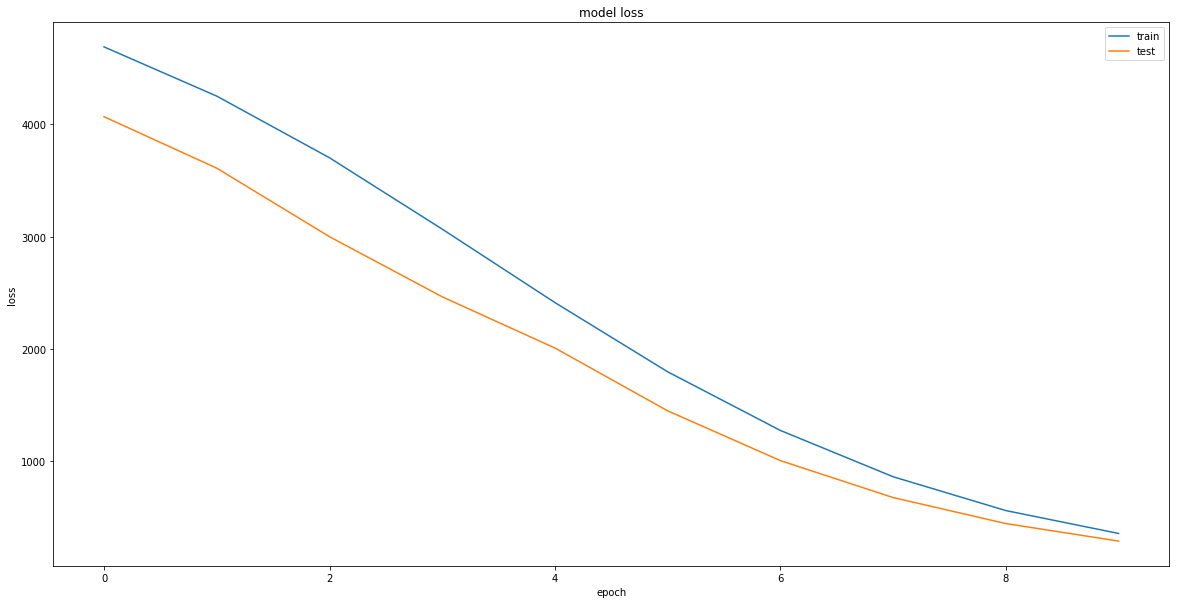

In [95]:
plot_loss_accuracy(trained_lon)